In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import precision_score, recall_score, r2_score, f1_score, confusion_matrix, roc_auc_score
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
import matplotlib.dates as mdates

In [2]:
start_date = datetime.strptime('2018-07-02', '%Y-%m-%d')
end_date = datetime.strptime('2023-07-01', '%Y-%m-%d')

dir_list = [item for item in os.listdir(os.getcwd()) if os.path.isdir(item)]
dir_list = [item for item in dir_list if item.split('_')[1] == '63']

###
dir_list = ['50elefin_63']
###

In [3]:
def std(df):
    scaler = StandardScaler()
    df_copy = df.copy()  # 複製DataFrame
    numeric_columns = df_copy.select_dtypes(include=['float64', 'int64']).columns
    df_copy[numeric_columns] = scaler.fit_transform(df_copy[numeric_columns])
    return df_copy

def bm_model(X, y):
    n = len(X)
    train_size = int(n * 0.8)

    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]
    lr_model = LogisticRegression(max_iter=10000, random_state=42, multi_class='ovr')
    xgb_model = XGBClassifier(eval_metric='mlogloss', random_state=42)

    lr_model.fit(X_train, y_train)
    y_pred_train_lr = lr_model.predict(X_train)
    y_pred_test_lr = lr_model.predict(X_test)
    y_pred_proba_train_lr = lr_model.predict_proba(X_train)[:, 1]
    y_pred_proba_test_lr = lr_model.predict_proba(X_test)[:, 1]

    predict_proba_train_lr = pd.DataFrame(y_pred_proba_train_lr)
    predict_proba_test_lr = pd.DataFrame(y_pred_proba_test_lr)
    predict_proba_lr = pd.concat([predict_proba_train_lr, predict_proba_test_lr], axis=0)
    predict_proba_lr.index = X.index

    xgb_model.fit(X_train, y_train)
    y_pred_train_xgb = xgb_model.predict(X_train)
    y_pred_test_xgb = xgb_model.predict(X_test)
    y_pred_proba_train_xgb = xgb_model.predict_proba(X_train)[:, 1]
    y_pred_proba_test_xgb = xgb_model.predict_proba(X_test)[:, 1]

    predict_proba_train_xgb = pd.DataFrame(y_pred_proba_train_xgb)
    predict_proba_test_xgb = pd.DataFrame(y_pred_proba_test_xgb)
    predict_proba_xgb = pd.concat([predict_proba_train_xgb, predict_proba_test_xgb], axis=0)
    predict_proba_xgb.index = X.index

    return y_pred_train_lr, y_pred_test_lr, y_pred_proba_train_lr, y_pred_proba_test_lr, y_pred_train_xgb, y_pred_test_xgb, y_pred_proba_train_xgb, y_pred_proba_test_xgb

In [4]:
BCI = pd.read_csv('../00 Raw Data/Indicator.csv', index_col=0, parse_dates=True).rename_axis(None, axis=0)
BCI.index = (BCI.index + pd.offsets.MonthBegin(1)) + pd.offsets.MonthEnd(0)
BCI.columns = ['BCI']
BCI_std = std(BCI)

BCI_Real = pd.read_csv('../00 Raw Data/Indicator.csv', index_col=0, parse_dates=True).rename_axis(None, axis=0)
BCI_Real.index = BCI_Real.index + pd.offsets.MonthEnd(0)
BCI_Real.columns = ['BCI']
BCI_Real_std = std(BCI_Real)

LEI = pd.read_csv('../00 Raw Data/Leading_Indicator.csv', index_col=0, parse_dates=True).rename_axis(None, axis=0)
LEI.index = (LEI.index + pd.offsets.MonthBegin(1)) + pd.offsets.MonthEnd(0)
LEI.columns = ['LEI']
LEI_std = std(LEI)

COI = pd.read_csv('../00 Raw Data/Coincident_Indicator.csv', index_col=0, parse_dates=True).rename_axis(None, axis=0)
COI.index = (COI.index + pd.offsets.MonthBegin(1)) + pd.offsets.MonthEnd(0)
COI.columns = ['COI']
COI_std = std(COI)

LAI = pd.read_csv('../00 Raw Data/Lagging_Indicator.csv', index_col=0, parse_dates=True).rename_axis(None, axis=0)
LAI.index = (LAI.index + pd.offsets.MonthBegin(1)) + pd.offsets.MonthEnd(0)
LAI.columns = ['LAI']
LAI_std = std(LAI)

macro = pd.read_csv('../00 Raw Data/macro_return.csv', index_col=0, parse_dates=True).rename_axis(None, axis=0)
macro_std = std(macro)

SVI = pd.read_csv('../00 Raw Data/SVI.csv', index_col=0, parse_dates=True).rename_axis(None, axis=0)
SVI_std = std(SVI)

VIXTWN = pd.read_csv('../00 Raw Data/VIXTWN.csv', index_col=0, parse_dates=True).rename_axis(None, axis=0)
VIXTWN_std = std(VIXTWN)

In [5]:
folder = '50elefin_63'
company = folder.split('_')[0]
ncol_xx0 = int(folder.split('_')[0][:2])
ws = int(folder.split('_')[1])

full_lambda = pd.read_csv(f'../02 Modeling/{folder}/full_lambda.csv', index_col=0, parse_dates=True)
full_lambda_mean = full_lambda.mean(axis=1)

full_lambda_mean_weekly = full_lambda_mean.resample('W-FRI').mean()
full_lambda_mean_weekly = full_lambda_mean_weekly.dropna()

full_lambda_mean_monthly = full_lambda_mean.resample('M').mean()
full_lambda_mean_monthly = full_lambda_mean_monthly.dropna()

FRM = pd.DataFrame()
for lag in range(ws):
    FRM[f'FRM_lag_{lag}'] = full_lambda_mean.shift(lag)
FRM = FRM.dropna()
FRM_std = std(FRM)

FRM_weekly = pd.DataFrame()
for lag in range(round(ws/5)):
    FRM_weekly[f'FRM_lag_{lag}'] = full_lambda_mean_weekly.shift(lag)
FRM_weekly = FRM_weekly.dropna()
FRM_weekly_std = std(FRM_weekly)

FRM_weekly_lag = FRM.resample('W-FRI').last()
FRM_weekly_lag = FRM_weekly_lag.dropna()
FRM_weekly_lag_std = std(FRM_weekly_lag)

FRM_weekly_diff_lag = FRM_weekly_lag - FRM_weekly_lag.shift(1)
FRM_weekly_diff_lag = FRM_weekly_diff_lag.dropna()
FRM_weekly_diff_lag_std = std(FRM_weekly_diff_lag)

FRM_monthly = pd.DataFrame()
for lag in range(6):
    FRM_monthly[f'FRM_lag_{lag}'] = full_lambda_mean_monthly.shift(lag)
FRM_monthly = FRM_monthly.dropna()
FRM_monthly_std = std(FRM_monthly)

FRM_monthly_lag = FRM.resample('M').last()
FRM_monthly_lag_std = std(FRM_monthly_lag)

FRM_monthly_diff_lag = FRM_monthly_lag - FRM_monthly_lag.shift(1)
FRM_monthly_diff_lag = FRM_monthly_diff_lag.dropna()
FRM_monthly_diff_lag = FRM_monthly_diff_lag.loc[FRM_monthly.index]
FRM_monthly_diff_lag_std = std(FRM_monthly_diff_lag)

SVI_lag = pd.DataFrame()
for lag in range(ws):
    SVI_lag[f'SVI_lag_{lag}'] = SVI['金融危機'].shift(lag)
SVI_lag = SVI_lag.dropna()
SVI_lag_std = std(SVI_lag)

SVI_weekly = SVI['金融危機'].resample('W-FRI').mean()
SVI_weekly = SVI_weekly.dropna()
SVI_weekly_std = std(pd.DataFrame(SVI_weekly))

SVI_lag_weekly = pd.DataFrame()
for lag in range(round(ws/5)):
    SVI_lag_weekly[f'SVI_lag_{lag}'] = SVI_weekly.shift(lag)
SVI_lag_weekly = SVI_lag_weekly.dropna()
SVI_lag_weekly_std = std(SVI_lag_weekly)

SVI_monthly = SVI['金融危機'].resample('M').mean()
SVI_monthly = SVI_monthly.dropna()
SVI_monthly_std = std(pd.DataFrame(SVI_monthly))

SVI_lag_monthly = pd.DataFrame()
for lag in range(6):
    SVI_lag_monthly[f'SVI_lag_{lag}'] = SVI_monthly.shift(lag)
SVI_lag_monthly = SVI_lag_monthly.dropna()
SVI_lag_monthly_std = std(SVI_lag_monthly)

VIXTWN_lag = pd.DataFrame()
for lag in range(ws):
    VIXTWN_lag[f'VIXTWN_lag_{lag}'] = VIXTWN['VIXTWN'].shift(lag)
VIXTWN_lag = VIXTWN_lag.dropna()
VIXTWN_lag_std = std(VIXTWN_lag)

VIXTWN_weekly = VIXTWN.resample('W-FRI').mean()
VIXTWN_weekly = VIXTWN_weekly.dropna()
VIXTWN_weekly_std = std(VIXTWN_weekly)

VIXTWN_lag_weekly = pd.DataFrame()
for lag in range(round(ws/5)):
    VIXTWN_lag_weekly[f'VIXTWN_lag_{lag}'] = VIXTWN_weekly.shift(lag)
VIXTWN_lag_weekly = VIXTWN_lag_weekly.dropna()
VIXTWN_lag_weekly_std = std(VIXTWN_lag_weekly)

VIXTWN_monthly = VIXTWN.resample('M').mean()
VIXTWN_montly = VIXTWN_monthly.dropna()
VIXTWN_monthly_std = std(VIXTWN_monthly)

VIXTWN_lag_monthly = pd.DataFrame()
for lag in range(6):
    VIXTWN_lag_monthly[f'VIXTWN_lag_{lag}'] = VIXTWN_monthly.shift(lag)
VIXTWN_lag_monthly = VIXTWN_lag_monthly.dropna()
VIXTWN_lag_monthly_std = std(VIXTWN_lag_monthly)

In [6]:
BCI_daily = BCI.resample('D').ffill()
BCI_daily = BCI_daily.loc[FRM.index]
BCI_daily_std = std(BCI_daily)

BCI_weekly = BCI.resample('W-FRI').ffill()
BCI_weekly = BCI_weekly.dropna()
BCI_weekly = BCI_weekly.loc[FRM_weekly.index]
BCI_weekly_std = std(BCI_weekly)

BCI_Real_daily = BCI_Real.resample('D').ffill()
BCI_Real_daily = BCI_Real_daily.loc[FRM.index]
BCI_Real_daily_std = std(BCI_Real_daily)

BCI_Real_weekly = BCI_Real.resample('W-FRI').ffill()
BCI_Real_weekly = BCI_Real_weekly.loc[FRM_weekly.index]
BCI_Real_weekly_std = std(BCI_Real_weekly)

LEI_daily = LEI.resample('D').ffill()
LEI_daily = LEI_daily.loc[FRM.index]
LEI_daily_std = std(LEI_daily)

LEI_weekly = LEI.resample('W-FRI').ffill()
LEI_weekly = LEI_weekly.loc[FRM_weekly.index]
LEI_weekly_std = std(LEI_weekly)

COI_daily = COI.resample('D').ffill()
COI_daily = COI_daily.loc[FRM.index]
COI_daily_std = std(COI_daily)

COI_weekly = COI.resample('W-FRI').ffill()
COI_weekly = COI_weekly.loc[FRM_weekly.index]
COI_weekly_std = std(COI_weekly)

LAI_daily = LAI.resample('D').ffill()
LAI_daily = LAI_daily.loc[FRM.index]
LAI_daily_std = std(LAI_daily)

LAI_weekly = LAI.resample('W-FRI').ffill()
LAI_weekly = LAI_weekly.loc[FRM_weekly.index]
LAI_weekly_std = std(LAI_weekly)

macro_daily = macro.loc[FRM.index]
macro_daily_std = std(macro_daily)

macro_weekly = macro.resample('W-FRI').mean()
macro_weekly = macro_weekly.dropna()
macro_weekly = macro_weekly.loc[FRM_weekly.index]
macro_weekly_std = std(macro_weekly)

macro_monthly = macro.resample('M').mean()
macro_monthly = macro_monthly.dropna()
macro_monthly = macro_monthly.loc[FRM_monthly.index]
macro_monthly_std = std(macro_monthly)

SVI_daily = SVI_lag.loc[FRM.index]
SVI_daily_std = std(SVI_daily)

SVI_lag_weekly = SVI_lag_weekly.loc[FRM_weekly.index]
SVI_lag_weekly_std = std(SVI_lag_weekly)

SVI_lag_monthly = SVI_lag_monthly.loc[FRM_monthly.index]
SVI_lag_monthly_std = std(SVI_lag_monthly)

VIXTWN_daily = VIXTWN_lag.loc[FRM.index]
VIXTWN_daily_std = std(VIXTWN_daily)

VIXTWN_lag_weekly = VIXTWN_lag_weekly.loc[FRM_weekly.index]
VIXTWN_lag_weekly_std = std(VIXTWN_lag_weekly)

VIXTWN_lag_monthly = VIXTWN_lag_monthly.loc[FRM_monthly.index]
VIXTWN_lag_monthly_std = std(VIXTWN_lag_monthly)

In [7]:
def score_to_recession(score):
    if 9 <= score <= 22:
        return 1
    else:
        return 0

BCI_daily['Recession'] = BCI_daily['BCI'].apply(score_to_recession)
BCI_daily_std['Recession'] = BCI_daily['BCI'].apply(score_to_recession)

BCI_Real_daily['Recession'] = BCI_Real_daily['BCI'].apply(score_to_recession)
BCI_Real_daily_std['Recession'] = BCI_Real_daily['BCI'].apply(score_to_recession)

BCI_weekly['Recession'] = BCI_weekly['BCI'].apply(score_to_recession)
BCI_weekly_std['Recession'] = BCI_weekly['BCI'].apply(score_to_recession)

BCI_Real_weekly['Recession'] = BCI_Real_weekly['BCI'].apply(score_to_recession)
BCI_Real_weekly_std['Recession'] = BCI_Real_weekly['BCI'].apply(score_to_recession)

BCI_monthly = pd.DataFrame()
BCI_monthly['BCI'] = BCI['BCI']
BCI_monthly = BCI_monthly.loc[FRM_monthly.index]
BCI_monthly_std = std(BCI_monthly)

BCI_monthly['Recession'] = BCI['BCI'].apply(score_to_recession)
BCI_monthly_std['Recesion'] = BCI['BCI'].apply(score_to_recession)

BCI_Real_monthly = pd.DataFrame()
BCI_Real_monthly['BCI'] = BCI_Real['BCI']
BCI_Real_monthly = BCI_monthly.loc[FRM_monthly.index]
BCI_Real_monthly_std = std(BCI_Real_monthly)

BCI_Real_monthly['Recession'] = BCI_Real['BCI'].apply(score_to_recession)
BCI_Real_monthly_std['Recession'] = BCI_Real['BCI'].apply(score_to_recession)

BCI_monthly_lag = pd.DataFrame()
BCI_monthly_lag['BCI'] = BCI['BCI']
BCI_monthly_lag = BCI_monthly_lag.loc[FRM_monthly_lag.index]
BCI_monthly_lag_std = std(BCI_monthly)

BCI_monthly_lag['Recession'] = BCI['BCI'].apply(score_to_recession)
BCI_monthly_lag_std['Recession'] = BCI['BCI'].apply(score_to_recession)

BCI_Real_monthly_lag = pd.DataFrame()
BCI_Real_monthly_lag['BCI'] = BCI_Real['BCI']
BCI_Real_monthly_lag = BCI_monthly_lag.loc[FRM_monthly_lag.index]
BCI_Real_monthly_lag_std = std(BCI_Real_monthly_lag)

BCI_Real_monthly_lag['Recession'] = BCI_Real['BCI'].apply(score_to_recession)
BCI_Real_monthly_lag_std['Recession'] = BCI_Real['BCI'].apply(score_to_recession)

In [15]:
data_chooses = ['Single', 'Multi', 'BM']
data_chooses = ['Single']
data_chooses = ['Multi']
A = [SVI_lag_monthly_std, VIXTWN_lag_monthly_std]
B = [FRM_monthly_lag_std.loc[SVI_lag_monthly.index]]
C = [BCI_monthly_std['BCI'].loc[SVI_lag_monthly.index]]
D = [LEI_std.loc[SVI_lag_monthly.index], COI_std.loc[SVI_lag_monthly.index], LAI_std.loc[SVI_lag_monthly.index]]

for data_choose in data_chooses:
    print('-----')
    print()

    if data_choose == 'Single':
        X = pd.concat(B + D, axis=1)
        X_name = 'B+D'
    elif data_choose == 'BM':
        X = pd.concat(A + D, axis=1)
        X_name = 'A+D'
    else:
        X = pd.concat(B + A + D, axis=1)
        X_name = 'B+A+D'
    
    y = BCI_Real_monthly_std['Recession']
    n = len(X)
    train_size = int(n * 0.8)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    models = {
        "Logistic Regression": LogisticRegression(max_iter=10000, random_state=42, multi_class='ovr'),
        # "XGBoost": XGBClassifier(eval_metric='mlogloss', random_state=42)
    }

    model_performance = {}

    for name, model in models.items():
        print(data_choose, ',', name)
        model.fit(X_train, y_train)
        y_pred_train = model.predict(X_train)
        y_pred_test = model.predict(X_test)
        y_pred_proba_train = model.predict_proba(X_train)[:, 1]
        y_pred_proba_test = model.predict_proba(X_test)[:, 1]

        print('In-sample Accuracy   =', f'{accuracy_score(y_train, y_pred_train):.4f}')
        print('In-sample AUC-ROC    =', f'{roc_auc_score(y_train, y_pred_proba_train):.4f}')
        print('Out-sample: Accuracy =',f'{accuracy_score(y_test, y_pred_test):.4f}')
        print('Out-sample AUC-ROC   =', f'{roc_auc_score(y_test, y_pred_proba_test):.4f}')

        print()

-----

Multi , Logistic Regression
In-sample Accuracy   = 1.0000
In-sample AUC-ROC    = 1.0000
Out-sample: Accuracy = 0.8182
Out-sample AUC-ROC   = 0.7000



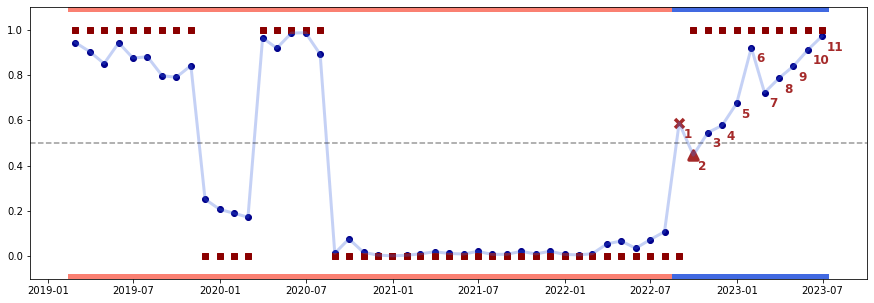

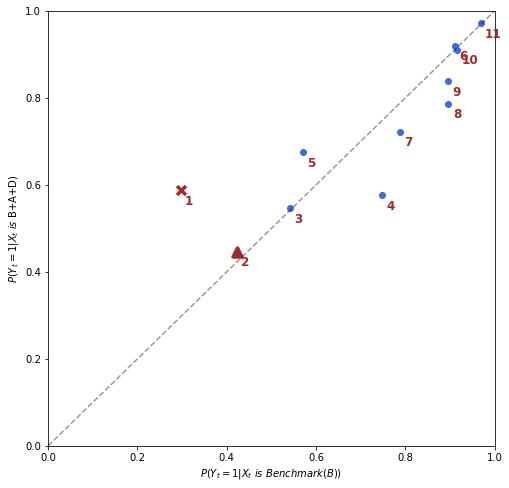

In [27]:
test1 = pd.DataFrame(y_pred_proba_train)
test2 = pd.DataFrame(y_pred_proba_test)
test3 = pd.concat([test1, test2], axis=0)
test3.index = FRM_monthly_diff_lag.index

y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)
y_pred_proba_train = model.predict_proba(X_train)[:, 1]
y_pred_proba_test = model.predict_proba(X_test)[:, 1]

predict_proba_train = pd.DataFrame(y_pred_proba_train, index=X_train.index)
predict_proba_test = pd.DataFrame(y_pred_proba_test, index=X_test.index)
predict_proba = pd.concat([predict_proba_train, predict_proba_test], axis=0)

plt.figure(figsize=(15,5))

train_test_split = len(predict_proba_train)

plt.hlines(y = 1.1, xmin=predict_proba.index[0] - pd.DateOffset(days=15), xmax=predict_proba.index[train_test_split] - pd.DateOffset(days=15), color='salmon', linestyle='-', linewidth=10)
plt.hlines(y = -0.1, xmin=predict_proba.index[0] - pd.DateOffset(days=15), xmax=predict_proba.index[train_test_split] - pd.DateOffset(days=15), color='salmon', linestyle='-', linewidth=10)
plt.hlines(y = 1.1, xmin=predict_proba.index[train_test_split]- pd.DateOffset(days=15), xmax= predict_proba.index[-1] + pd.DateOffset(days=15), color='royalblue', linestyle='-', linewidth=10)
plt.hlines(y = -0.1, xmin=predict_proba.index[train_test_split]- pd.DateOffset(days=15), xmax= predict_proba.index[-1] + pd.DateOffset(days=15), color='royalblue', linestyle='-', linewidth=10)
# plt.plot(BCI_Real_monthly['Recession'], linewidth=2, color='k', alpha=0.7)
plt.plot(test3, linewidth=3, color='royalblue', alpha=0.3)

start_index = int(len(test3) * 0.8)
for i in range(len(test3)):
    if BCI_Real_monthly['Recession'].iloc[i] == 1 and test3.values[i] < 0.5:
        plt.scatter(test3.index[i], test3.values[i], color='brown', marker='^', s=80, lw=3.5, alpha=1)
    elif BCI_Real_monthly['Recession'].iloc[i] == 0 and test3.values[i] > 0.5:
        plt.scatter(test3.index[i], test3.values[i], color='brown', marker='x', s=80, lw=3.5, alpha=1)
    else:
        plt.scatter(test3.index[i], test3.values[i], color='darkblue', alpha=1)
    if i >= start_index:
        date_num = mdates.date2num(test3.index[i])
        offset_x = 10  # 以天為單位調整此值
        plt.text(date_num + offset_x, test3.values[i] - 0.02, str(i - start_index + 1), 
                 color='brown', fontsize=12, fontweight='heavy', ha='left', va='top')
plt.scatter(BCI_Real_monthly['Recession'].index, BCI_Real_monthly['Recession'], color='darkred', marker='s', alpha=1)
plt.axhline(y=0.5, color='k', linestyle='--',  alpha=0.4)
plt.ylim(-0.1, 1.1)
plt.show()



X_bm = pd.concat(A + D, axis=1)
y_bm = BCI_Real_monthly_std['Recession']
y_pred_train_lr, y_pred_test_lr, y_pred_proba_train_lr, y_pred_proba_test_lr, y_pred_train_xgb, y_pred_test_xgb, y_pred_proba_train_xgb, y_pred_proba_test_xgb = bm_model(X_bm, y_bm)

plt.figure(figsize=(8,8))
for i in range(len(y_pred_proba_test)):
    if BCI_Real_monthly['Recession'].iloc[len(BCI_Real_monthly) - len(y_pred_proba_test) + i] == 1 and y_pred_proba_test[i] < 0.5:
        plt.scatter(y_pred_proba_test_lr[i], y_pred_proba_test[i], color='brown', marker='^', s=80, lw=3.5, alpha=1)
    elif BCI_Real_monthly['Recession'].iloc[len(BCI_Real_monthly) - len(y_pred_proba_test) + i] == 0 and y_pred_proba_test[i] > 0.5:
        plt.scatter(y_pred_proba_test_lr[i], y_pred_proba_test[i], color='brown', marker='x', s=80, lw=3.5, alpha=1)
    else:
        plt.scatter(y_pred_proba_test_lr[i], y_pred_proba_test[i], color='royalblue', alpha=1)

for i, (x, y) in enumerate(zip(y_pred_proba_test_lr, y_pred_proba_test)):
    plt.text(x+0.01, y-0.01, str(i + 1), color='brown', fontweight='heavy', fontsize=12, ha='left', va='top')
plt.xlabel(r'$P(Y_t=1|X_t$ $is$ $Benchmark (B))$')
plt.ylabel(r'$P(Y_t=1|X_t$ $is$ ' + f'{X_name}' + r'$)$', rotation=90)
plt.plot([0, 1], [0, 1], 'k--', alpha=0.4)
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.show()


In [24]:
text = 'F+B'

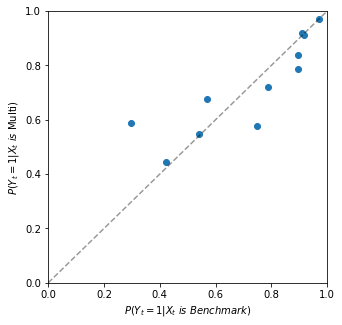

In [25]:
X_bm = pd.concat(A + D, axis=1)
y_bm = BCI_Real_monthly_std['Recession']
y_pred_train_lr, y_pred_test_lr, y_pred_proba_train_lr, y_pred_proba_test_lr, y_pred_train_xgb, y_pred_test_xgb, y_pred_proba_train_xgb, y_pred_proba_test_xgb = bm_model(X_bm, y_bm)

plt.figure(figsize=(5,5))
plt.scatter(y_pred_proba_test_lr, y_pred_proba_test)
plt.xlabel(r'$P(Y_t=1|X_t$ $is$ $Benchmark)$')
plt.ylabel(r'$P(Y_t=1|X_t$ $is$ ' + f'{data_choose}' + r'$)$', rotation=90)
plt.plot([0, 1], [0, 1], 'k--', alpha=0.4)
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.show()


In [50]:
full_lambda

,2330,2317,2454,2382,2412,2308,2303,3711,3045,2395,...,2812,2838,2845,2809,2889,6005,2855,2897,2867,2849
2018-09-28,0.455800,0.458954,0.460254,0.439206,0.504015,0.623984,0.347242,0.580709,0.568430,0.586962,...,0.626637,0.587529,0.536713,0.443852,0.572270,0.578945,0.320384,0.332136,0.581457,0.537915
2018-10-01,0.446720,0.524061,0.595077,0.389995,0.565047,0.583363,0.409121,0.895315,0.591058,0.521316,...,0.755091,0.760590,0.605166,0.788201,0.551322,0.521739,0.347889,0.927939,0.699005,0.490514
2018-10-02,0.693070,0.612394,0.463822,0.468573,0.556502,0.386193,0.447676,0.896341,0.612223,0.678686,...,0.521022,0.370933,0.855450,0.733292,0.738997,0.504881,0.454568,0.945172,0.698373,0.378928
2018-10-03,0.675345,0.590810,0.455123,0.362052,0.503664,0.432526,0.466794,0.527760,0.590037,0.672279,...,0.514028,0.408390,0.469867,0.746309,0.768642,0.398696,0.409296,0.993802,0.828937,0.346120
2018-10-04,0.627098,0.372700,0.547934,0.357539,0.705046,0.439274,0.679206,0.915500,0.586734,0.602970,...,0.407174,0.493909,0.473555,0.495959,0.564917,0.608943,0.479617,0.525612,1.016516,0.325573
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-26,0.454543,0.650150,0.464174,0.363586,0.487774,0.451216,0.570801,0.345756,0.400904,0.468177,...,0.640757,0.473942,0.466728,0.468461,0.504673,0.439905,0.549395,0.279431,0.516154,0.482610
2023-06-27,0.744812,0.735912,0.553060,0.471580,0.615260,0.589547,0.536742,0.372794,0.706731,0.524326,...,0.602574,0.471248,0.453094,0.435679,0.539453,0.580916,0.510215,0.401368,0.375547,0.596640
2023-06-28,0.749904,0.415379,0.494787,0.306772,0.614564,0.572517,0.540917,0.449121,0.662228,0.457744,...,0.429602,0.509802,0.506322,0.399132,0.540375,0.646328,0.491743,0.360735,0.517992,0.480713
2023-06-29,0.780119,0.856858,0.521710,0.331105,0.671003,0.493804,0.423239,0.339957,0.662784,0.369444,...,0.449319,0.463710,0.493505,0.403466,0.592287,0.516714,0.569098,0.328804,0.376435,0.660683


In [56]:
FRM_monthly_lag = pd.DataFrame()
for lag in range(6):
    FRM_monthly_lag[f'FRM_monthly_lag_{lag}'] = full_lambda_mean_monthly.shift(lag)
FRM_monthly_lag = FRM_monthly_lag.dropna()
FRM_monthly_lag

,FRM_monthly_lag_0,FRM_monthly_lag_1,FRM_monthly_lag_2,FRM_monthly_lag_3,FRM_monthly_lag_4,FRM_monthly_lag_5
2019-02-28,0.545207,0.583665,0.641063,0.624991,0.603725,0.551030
2019-03-31,0.528583,0.545207,0.583665,0.641063,0.624991,0.603725
2019-04-30,0.523717,0.528583,0.545207,0.583665,0.641063,0.624991
2019-05-31,0.538363,0.523717,0.528583,0.545207,0.583665,0.641063
2019-06-30,0.526090,0.538363,0.523717,0.528583,0.545207,0.583665
2019-07-31,0.550666,0.526090,0.538363,0.523717,0.528583,0.545207
2019-08-31,0.552063,0.550666,0.526090,0.538363,0.523717,0.528583
2019-09-30,0.550360,0.552063,0.550666,0.526090,0.538363,0.523717
2019-10-31,0.559918,0.550360,0.552063,0.550666,0.526090,0.538363
2019-11-30,0.521390,0.559918,0.550360,0.552063,0.550666,0.526090


In [58]:
SVI_lag_monthly

,SVI_lag_0,SVI_lag_1,SVI_lag_2,SVI_lag_3,SVI_lag_4,SVI_lag_5
2019-02-28,9.919996,4.071992,9.006289,4.806543,7.186663,8.976936
2019-03-31,8.116443,9.919996,4.071992,9.006289,4.806543,7.186663
2019-04-30,5.057944,8.116443,9.919996,4.071992,9.006289,4.806543
2019-05-31,4.994384,5.057944,8.116443,9.919996,4.071992,9.006289
2019-06-30,4.881394,4.994384,5.057944,8.116443,9.919996,4.071992
2019-07-31,9.862555,4.881394,4.994384,5.057944,8.116443,9.919996
2019-08-31,4.237112,9.862555,4.881394,4.994384,5.057944,8.116443
2019-09-30,1.974915,4.237112,9.862555,4.881394,4.994384,5.057944
2019-10-31,8.722141,1.974915,4.237112,9.862555,4.881394,4.994384
2019-11-30,5.403070,8.722141,1.974915,4.237112,9.862555,4.881394
